# Response Time Simulation


More info on OSMNX:
Get street networks anywhere in the world from OpenStreetMap data then analyze and visualize them.

  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import numpy as np
import geopandas as gpd
import fiona
import osmnx as ox
import requests
import skmob
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import fiona
import warnings
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
warnings.filterwarnings("ignore")
import matplotlib.cm as cm
import matplotlib.colors as colors
import statistics
import os

import simulation_functions as sim

ox.config(use_cache=True, log_console=True)
ox.__version__

'1.0.1'

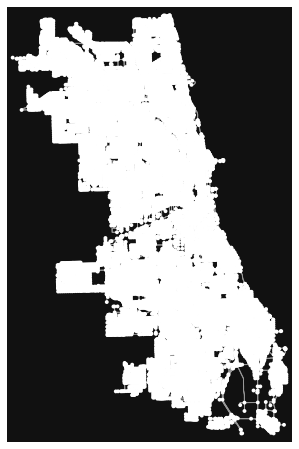

In [2]:
# get the walking network for piedmont
place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G)

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [4]:
# assign speeds and traversal times to the edges
for u, v, k, d in G.edges(keys=True, data=True):
    if 'residential' in d['highway']:
        d['speed'] = 20
    elif 'tertiary' in d['highway']:
        d['speed'] = 30
    elif 'secondary' in d['highway']:
        d['speed'] = 40
    else:
        d['speed'] = 25
    
    # calculate time to traverse edge, in minutes
    d['time'] = d['length'] / (d['speed'] * 1609.34 / 60) #miles/hour to meters/minute

## Run Scenarios

In [11]:
precent_operating_list=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90] 
data_dict={}

def run_daily_profile(csv,grouping,precent_operating_list):
        #this function runs for different staffing scenarios
        
    crime_data,polrep_crime_data,altrep_crime_data=sim.create_crime_dfs(csv,grouping)
    PS_data,cr_lat,cr_long=sim.create_police_station_df(csv='Police_Stations_-_Map.csv',folder='Simulation_Data')
    Gs = ox.utils_graph.get_largest_component(G, strongly=True)
    PC_node,Police_officers=sim.create_pc_node(PS_data,G,Gs,cr_lat,cr_long)
    polrep_crime_node,polrep_crime_geo=sim.get_nearest_crime_node(polrep_crime_data,Gs)
    altrep_crime_node,altrep_crime_geo=sim.get_nearest_crime_node(altrep_crime_data,Gs)
    polrep_time_min,polrep_ser_min=sim.create_time_sequence(polrep_crime_data)
    polrep_Crime = [polrep_time_min,polrep_crime_node,polrep_ser_min,polrep_crime_geo]
    altrep_time_min,altrep_ser_min=sim.create_time_sequence(altrep_crime_data)
    alt_rep_Crime = [altrep_time_min,altrep_crime_node,altrep_ser_min,altrep_crime_geo]
    
    polys=sim.create_polys(PS_data,Gs, shp='Chicago_PB.shp',folder='Simulation_Data')
    ndk=sim.set_ndk(Gs,PC_node)
    
    for percent_operating in precent_operating_list:
        polrep_RT,polrep_Officers_maxed_out=sim.eva_resp_time(PC_node,polrep_Crime,percent_operating,ndk,polys,Gs)  
        pol_res_time = sim.column(polrep_RT, 0)
        data_dict[str(grouping)+'_'+csv[:-13]+'_'+str(percent_operating)]=[np.mean(pol_res_time),np.median(pol_res_time),np.max(pol_res_time),polrep_Officers_maxed_out,pol_res_time]
        
        percent_responding=round(1-percent_operating,2)
        altrep_RT,altrep_Officers_maxed_out=sim.eva_resp_time(PC_node,polrep_Crime,percent_responding,ndk,polys,Gs)
        alt_res_time = sim.column(altrep_RT, 0)
        data_dict['non'+str(grouping)+'_'+csv[:-13]+'_'+str(percent_responding)]=[np.mean(alt_res_time),np.median(alt_res_time),np.max(alt_res_time),altrep_Officers_maxed_out,alt_res_time]
       



In [12]:
def run_BAU(csv):
        
    crime_data,gr1,gr2=sim.create_crime_dfs(csv,grouping='BAU')
    PS_data,cr_lat,cr_long=sim.create_police_station_df(csv='Police_Stations_-_Map.csv',folder='Simulation_Data')
    Gs = ox.utils_graph.get_largest_component(G, strongly=True)
    PC_node,Police_officers=sim.create_pc_node(PS_data,G,Gs,cr_lat,cr_long)
    crime_node,crime_geo=sim.get_nearest_crime_node(crime_data,Gs)
   
    time_min,ser_min=sim.create_time_sequence(crime_data)
    Crime = [time_min,crime_node,ser_min,crime_geo]
    
    polys=sim.create_polys(PS_data,Gs, shp='Chicago_PB.shp',folder='Simulation_Data')
    ndk=sim.set_ndk(Gs,PC_node)
    
    percent_operating=1.0
    RT,Officers_maxed_out=sim.eva_resp_time(PC_node,Crime,percent_operating,ndk,polys,Gs)  
    res_time = sim.column(RT, 0)
    data_dict['BAU'+'_'+csv[:-13]+'_'+str(percent_operating)]=[np.mean(res_time),np.median(res_time),np.max(res_time),Officers_maxed_out,res_time]
        


In [10]:
#run_BAU(csv='fall_worst_case_0_timestamp.csv')

BAU: No Groupings
Day Evaluating:  2014-10-01 00:00:00


In [9]:
#run_daily_profile(csv='fall_worst_case_0_timestamp.csv',grouping='Index',precent_operating_list=[0.9] )

In [13]:
arr = os.listdir('Chicago_Data/Daily_Profiles')
for csv in arr:
    print(csv)
    run_daily_profile(csv,'Index',precent_operating_list)
    run_daily_profile(csv,'Violent',precent_operating_list)
    run_BAU(csv)

Groups are Index and Non-index
Day Evaluating:  2014-10-22 00:00:00
Day Evaluating:  2014-10-22 00:00:00
Groups are Violent and Non-violent
Day Evaluating:  2014-10-22 00:00:00
Day Evaluating:  2014-10-22 00:00:00
BAU: No Groupings
Day Evaluating:  2014-10-22 00:00:00
Groups are Index and Non-index
Day Evaluating:  2014-09-01 00:00:00
Day Evaluating:  2014-09-01 00:00:00
Groups are Violent and Non-violent
Day Evaluating:  2014-09-01 00:00:00
Day Evaluating:  2014-09-01 00:00:00
BAU: No Groupings
Day Evaluating:  2014-09-01 00:00:00
Groups are Index and Non-index
Day Evaluating:  2014-06-01 00:00:00
Day Evaluating:  2014-06-01 00:00:00
Groups are Violent and Non-violent
Day Evaluating:  2014-06-01 00:00:00
Day Evaluating:  2014-06-01 00:00:00
BAU: No Groupings
Day Evaluating:  2014-06-01 00:00:00
Groups are Index and Non-index
Day Evaluating:  2014-08-01 00:00:00
Day Evaluating:  2014-08-01 00:00:00
Groups are Violent and Non-violent
Day Evaluating:  2014-08-01 00:00:00
Day Evaluating: 

In [14]:
def create_df(data_dict):
    df=pd.DataFrame(data_dict).T
    df.columns=['Mean','Median','Max','Officers Maxed','RTs']
    df['percentage']=[float(i[-3:]) for i in df.index]
    df['Reponder']=[(i[:3]=='non')*1 for i in df.index]
    df['Reponder']=df['Reponder'].map({1:'Alternative',0:'Police'})#this takes into account BAU#round RTs
    df['Grouping']=[a+b for a, b in zip([('Violent' in i)*1 for i in df.index], [('BAU' in i)*2 for i in df.index])]
    df['Grouping']=df['Grouping'].map({2:'BAU',1:'Violent',0:'Index'})
    return df

In [20]:
df=create_df(data_dict)
#df.to_csv('Chicago_Data/RT_Data_allscenarios.csv')
df

,Mean,Median,Max,Officers Maxed,RTs,percentage,Reponder,Grouping
Index_fall_0.5_0__0.1,3.22476,2.82957,29.465,3,"[7.364370922241418, 5.706187567574286, 2.17047...",0.1,Police,Index
nonIndex_fall_0.5_0__0.9,3.08067,2.81856,8.91461,0,"[7.364370922241418, 5.706187567574286, 2.17047...",0.9,Alternative,Index
Index_fall_0.5_0__0.2,3.08067,2.81856,8.91461,0,"[7.364370922241418, 5.706187567574286, 2.17047...",0.2,Police,Index
nonIndex_fall_0.5_0__0.8,3.08067,2.81856,8.91461,0,"[7.364370922241418, 5.706187567574286, 2.17047...",0.8,Alternative,Index
Index_fall_0.5_0__0.3,3.08067,2.81856,8.91461,0,"[7.364370922241418, 5.706187567574286, 2.17047...",0.3,Police,Index
...,...,...,...,...,...,...,...,...
Violent_winter_0.5_0__0.8,2.84275,2.70717,6.16276,0,"[4.20447612064573, 4.764127530540471, 2.620407...",0.8,Police,Violent
nonViolent_winter_0.5_0__0.2,2.84275,2.70717,6.16276,0,"[4.20447612064573, 4.764127530540471, 2.620407...",0.2,Alternative,Violent
Violent_winter_0.5_0__0.9,2.84275,2.70717,6.16276,0,"[4.20447612064573, 4.764127530540471, 2.620407...",0.9,Police,Violent
nonViolent_winter_0.5_0__0.1,2.84275,2.70717,6.16276,0,"[4.20447612064573, 4.764127530540471, 2.620407...",0.1,Alternative,Violent


# Below we have the process step-by-step for reference/de-bugging

### Format Crime Data

In [8]:

"""CSV Options
daily_profile='all_data_0.5_0_timestamp.csv'
daily_profile='fall_0.5_0_timestamp.csv'
daily_profile='spring_0.5_0_timestamp.csv'
daily_profile='winter_0.5_0_timestamp.csv'
daily_profile='summer_0.5_0_timestamp.csv'

daily_profile='all_data_worst_case_0_timestamp.csv'
daily_profile='spring_worst_case_0_timestamp.csv'
daily_profile='summer_worst_case_0_timestamp.csv'
daily_profile='winter_worst_case_0_timestamp.csv'
daily_profile='fall_worst_case_0_timestamp.csv

grouping options:
grouping='Violent'
grouping='Index'
'"""
crime_data,polrep_crime_data,altrep_crime_data=sim.create_crime_dfs(csv='fall_worst_case_0_timestamp.csv',grouping='Violent')


Groups are Violent and Non-violent


## Importing Police Location Data (Using that as location for police for basic simulation)

In [9]:
PS_data,cr_lat,cr_long=sim.create_police_station_df(csv='Police_Stations_-_Map.csv',folder='Simulation_Data')
Gs = ox.utils_graph.get_largest_component(G, strongly=True)
PC_node,Police_officers=sim.create_pc_node(PS_data,G,Gs,cr_lat,cr_long)

## Evaluating Response time based on the nearest police location to the crime

## Initialize varibales : no of police associated with police location, no of police needed based on crime, 

In [15]:
polrep_crime_node,polrep_crime_geo=sim.get_nearest_crime_node(polrep_crime_data,Gs)
altrep_crime_node,altrep_crime_geo=sim.get_nearest_crime_node(altrep_crime_data,Gs)

In [16]:
polrep_time_min,polrep_ser_min=sim.create_time_sequence(polrep_crime_data)
polrep_Crime = [polrep_time_min,polrep_crime_node,polrep_ser_min,polrep_crime_geo]

Day Evaluating:  2014-10-01 00:00:00


In [17]:
altrep_time_min,altrep_ser_min=sim.create_time_sequence(altrep_crime_data)
alt_rep_Crime = [altrep_time_min,altrep_crime_node,altrep_ser_min,altrep_crime_geo]

Day Evaluating:  2014-10-01 00:00:00


## Police Beats

In [19]:
warnings.filterwarnings("ignore")
polys=sim.create_polys(PS_data,Gs, shp='Chicago_PB.shp',folder='Simulation_Data')

In [20]:
polys.head()

,dist_label,dist_num,geometry,node,#Officers,NoOfOfficers
0,17TH,17,"POLYGON ((-87.71067 41.99737, -87.71067 41.997...",305911655,202.0,40.0
1,20TH,20,"POLYGON ((-87.66029 41.99092, -87.66029 41.990...",305527080,208.0,42.0
2,31ST,16,"POLYGON ((-87.82818 41.98384, -87.82816 41.983...",305905861,237.0,47.0
3,31ST,16,"POLYGON ((-87.83365 41.97535, -87.83366 41.974...",305905861,237.0,47.0
4,19TH,19,"POLYGON ((-87.64492 41.96973, -87.64431 41.969...",250278999,356.0,71.0


In [23]:
percent_operating=0.8
ndk=sim.set_ndk(Gs,PC_node)
Resp_time,Officers_maxed_out=sim.eva_resp_time(PC_node,polrep_Crime,percent_operating,ndk,polys,Gs)

no off 69.0 0.8
no off 71.0 0.8
no off 65.0 0.8
no off 68.0 0.8
no off 86.0 0.8
no off 73.0 0.8
no off 74.0 0.8
no off 66.0 0.8
no off 74.0 0.8
no off 71.0 0.8
no off 67.0 0.8
no off 73.0 0.8
no off 69.0 0.8
no off 59.0 0.8
no off 68.0 0.8
no off 71.0 0.8
no off 65.0 0.8
no off 71.0 0.8
no off 86.0 0.8
no off 49.0 0.8
no off 82.0 0.8
no off 66.0 0.8
no off 71.0 0.8
no off 73.0 0.8
no off 71.0 0.8
no off 82.0 0.8
no off 69.0 0.8
no off 82.0 0.8
no off 69.0 0.8
no off 73.0 0.8
no off 69.0 0.8
no off 69.0 0.8
no off 68.0 0.8
no off 71.0 0.8
no off 66.0 0.8
no off 86.0 0.8
no off 69.0 0.8
no off 66.0 0.8
no off 71.0 0.8
no off 68.0 0.8
no off 74.0 0.8
no off 71.0 0.8
no off 86.0 0.8
no off 49.0 0.8
no off 69.0 0.8
no off 69.0 0.8
no off 49.0 0.8
no off 71.0 0.8
no off 69.0 0.8
no off 68.0 0.8
no off 55.0 0.8
no off 71.0 0.8
no off 86.0 0.8
no off 66.0 0.8
no off 65.0 0.8
no off 49.0 0.8
no off 71.0 0.8
no off 82.0 0.8
no off 69.0 0.8
no off 86.0 0.8
no off 82.0 0.8
no off 69.0 0.8
no off 6

In [26]:
Resp_time

[[0.852313992071284, 0.0],
 [2.7034200355425204, 1.0],
 [1.3567937788161608, 1.0],
 [1.8082086445375127, 1.0],
 [3.491838890476842, 50.0],
 [2.260854760336536, 60.0],
 [1.626207327227311, 60.0],
 [3.6490045608758863, 97.0],
 [1.8183047087625988, 120.0],
 [1.68533908310239, 125.0],
 [2.4526184647122427, 195.0],
 [5.532587458212683, 276.0],
 [3.758539836206147, 284.0],
 [0.8003190749002698, 285.0],
 [2.3157017783687723, 440.0],
 [0.6966638497769271, 450.0],
 [3.3620863211005756, 465.0],
 [4.017296842183752, 540.0],
 [2.3416214100190142, 540.0],
 [1.8965712031018929, 540.0],
 [1.2277713224054583, 540.0],
 [3.0033936272012123, 560.0],
 [1.7986026569898221, 585.0],
 [5.461480109858701, 600.0],
 [3.8535660581356326, 618.0],
 [1.283450979904806, 630.0],
 [2.4015002423353673, 630.0],
 [2.4529241800986745, 656.0],
 [4.347292989672785, 660.0],
 [4.421163644723926, 665.0],
 [2.4504334074838137, 690.0],
 [4.982055003914648, 690.0],
 [1.7039979121876052, 694.0],
 [1.8984742813824305, 758.0],
 [6.01